# **`Model Fitting and Hyperparameter Tuning`**

1. Train few regression algorithm (with default hyperparams)
2. Evaluate their crossvalidation errors (**RMSE**)
3. Choose the best model with the lowest error
4. Tune the hyperparameters of the best model
5. Evaluate on the test data
6. Retrain the model on the whole data
7. Save the model by pickling it.  

## Autoreload modules

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Change project directory

In [27]:
import os
os.chdir('/content/drive/MyDrive/projects/data-science-explorations/mlops/mpg-pred-end-to-end-ml/notebooks')
os.listdir('../')

['README.md',
 'data',
 'notebooks',
 'src',
 'venv-hpx360-win',
 'requirements.txt',
 'scripts',
 'reports',
 'src.egg-info',
 'setup.py',
 'models',
 '.gitignore']

In [ ]:
!pip install -e ../.

## Some imports

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import src

## Load Data

In [29]:
from src.project import load_data
df = load_data()
df.head()

,mpg,cylinder,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## Split into train and test sets

In [30]:
from src.project.utils import split_into_train_and_test
dfX_train, dfy_train, dfX_test, dfy_test = split_into_train_and_test(df) # default stratify by cylinder

In [31]:
y_train, y_test = dfy_train.to_numpy().ravel(), dfy_test.to_numpy().ravel()

## Import the preprocessing pipeline

In [32]:
from src.project.preprocess import preprocessor, PREPROCESSED_COLUMNS

In [33]:
pd.DataFrame(preprocessor.fit_transform(dfX_train), columns=PREPROCESSED_COLUMNS)

,cylinder,displacement,horsepower,weight,acceleration,model_year,displacement_on_horsepower,weight_on_cylinder,acceleration_on_horsepower,acceleration_on_cylinder,origin_1,origin_2,origin_3
0,-0.856578,-1.078045,-1.147090,-1.172203,1.215869,-0.544364,-1.284523,-0.482243,2.073644,-0.729861,1.949410,1.201418,1.483644
1,-0.856578,-1.117458,-0.985534,-1.175813,0.130698,-0.544364,-1.284523,2.073644,-0.482243,-0.189710,1.517374,1.208546,1.662800
2,-0.856578,-0.358749,-0.312382,-0.471828,-0.411887,1.636520,0.778499,-0.482243,-0.482243,0.180942,-0.277037,0.529567,0.031415
3,0.322607,0.567467,-0.420087,0.194851,-0.411887,-1.362195,0.778499,-0.482243,-0.482243,-1.159033,-0.849319,-0.641330,-0.927575
4,-0.856578,-0.930244,-0.366234,-0.856914,-0.050164,-0.816974,-1.284523,2.073644,-0.482243,0.916085,0.790845,0.594925,0.901569
...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,-0.856578,-1.009071,-0.770125,-1.045847,-0.050164,-0.544364,-1.284523,2.073644,-0.482243,0.178956,1.021060,0.964710,1.208442
314,1.501793,2.045472,1.787851,2.034839,-1.497058,-0.271753,0.778499,-0.482243,-0.482243,0.327827,-1.328285,-1.484094,-1.310549
315,-0.856578,-0.565670,-0.527791,-0.820812,-1.460886,1.636520,0.778499,-0.482243,-0.482243,0.360307,-0.392035,1.045166,0.355917
316,-0.856578,-0.782444,-0.231604,-0.728151,-0.231025,-1.634806,-1.284523,-0.482243,2.073644,0.972037,0.374597,0.245228,0.403785


## Add ML Model to Pipeline

In [34]:
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

model = Pipeline([
    ('preprocess', preprocessor),
    ('reg', LinearRegression())
])

## Find the best ML model

In [35]:
from sklearn.model_selection import GridSearchCV


param_grid = {'reg': [LinearRegression(), Ridge(), Lasso(), DecisionTreeRegressor(),
                      RandomForestRegressor(), AdaBoostRegressor(), ExtraTreesRegressor(), SVR()]}
                      
grid_search = GridSearchCV(model, param_grid, scoring = 'neg_mean_squared_error', n_jobs=-1, return_train_score=True, cv=5)


In [36]:
%%time
grid_search.fit(dfX_train, y_train)

CPU times: user 419 ms, sys: 7.92 ms, total: 427 ms
Wall time: 3.24 s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        Pipeline(memory=None,
                                                 steps=[('feature_union',
                                                         FeatureUnion(n_jobs=None,
                                                                      transformer_list=[('imputer',
                                                                                         Pipeline(memory=None,
                                                                                                  steps=[('drop_cols',
                                                                                                          ColumnTransformer(n_jobs=None,
                                                                                                                            remainder='passthrough',
                              

## See the best performing `ML` Model

In [37]:
print('Best ML Model:', grid_search.best_params_['reg'].__class__.__name__)
print('Lowest MSE: ', -grid_search.best_score_)

Best ML Model: ExtraTreesRegressor
Lowest MSE:  6.853263920833328


## Analyze the `GridSearchCV` results

In [38]:
gsdf = pd.DataFrame(grid_search.cv_results_)
gsdf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.036710,0.004368,0.006511,0.000590,"LinearRegression(copy_X=True, fit_intercept=Tr...","{'reg': LinearRegression(copy_X=True, fit_inte...",-9.148538,-9.892453,-5.941754,-9.525043,-10.178172,-8.937192,1.537234,5,-8.003644,-7.668819e+00,-8.718574,-7.806587,-7.615852,-7.962695,0.401014
1,0.036784,0.003838,0.006815,0.000345,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...","{'reg': Ridge(alpha=1.0, copy_X=True, fit_inte...",-8.772302,-9.929682,-5.898450,-9.534427,-10.323222,-8.891617,1.581996,4,-8.060098,-7.702680e+00,-8.752713,-7.835012,-7.645924,-7.999285,0.402784
2,0.038922,0.008410,0.006501,0.000462,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","{'reg': Lasso(alpha=1.0, copy_X=True, fit_inte...",-8.543044,-13.537515,-8.031968,-11.138491,-12.760255,-10.802255,2.200318,7,-10.691018,-9.787256e+00,-10.966681,-10.078352,-9.891770,-10.283015,0.463595
3,0.042479,0.008686,0.006584,0.000380,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...","{'reg': DecisionTreeRegressor(ccp_alpha=0.0, c...",-10.211875,-13.502187,-12.495938,-13.024127,-15.710476,-12.988921,1.767855,8,-0.000000,-0.000000e+00,-0.000000,-0.000000,-0.000000,0.000000,0.000000
4,0.382522,0.010009,0.018429,0.000727,"RandomForestRegressor(bootstrap=True, ccp_alph...","{'reg': RandomForestRegressor(bootstrap=True, ...",-5.578959,-8.184111,-6.406173,-7.971825,-10.515100,-7.731233,1.697113,2,-1.109795,-1.147780e+00,-1.153321,-0.978338,-0.982754,-1.074398,0.078093
5,0.156381,0.010988,0.012289,0.000764,"AdaBoostRegressor(base_estimator=None, learnin...","{'reg': AdaBoostRegressor(base_estimator=None,...",-6.473705,-8.474052,-7.354212,-8.779534,-9.061267,-8.028554,0.969663,3,-4.646039,-4.044662e+00,-4.138363,-4.222713,-4.239734,-4.258302,0.205902
6,0.232959,0.040233,0.017317,0.003311,"ExtraTreesRegressor(bootstrap=False, ccp_alpha...","{'reg': ExtraTreesRegressor(bootstrap=False, c...",-6.054107,-6.083202,-5.059260,-6.934673,-10.135079,-6.853264,1.745110,1,-0.000016,-7.874016e-07,-0.000011,-0.000004,-0.000010,-0.000008,0.000005
7,0.038950,0.007300,0.006957,0.000894,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...","{'reg': SVR(C=1.0, cache_size=200, coef0=0.0, ...",-6.168240,-12.187406,-9.972687,-11.595085,-13.949680,-10.774619,2.631044,6,-10.318638,-9.280431e+00,-9.888359,-9.698993,-8.772959,-9.591876,0.528239


In [39]:
model_compdf = gsdf[['param_reg', 'rank_test_score', 'mean_fit_time', 'mean_train_score', 'mean_test_score', 'std_train_score', 'std_test_score']].copy()
model_compdf['mean_train_mse'] = -model_compdf['mean_train_score']
model_compdf['mean_test_mse'] = -model_compdf['mean_test_score']
model_compdf['param_reg_name'] = model_compdf['param_reg'].apply(lambda m: m.__class__.__name__)

In [40]:
model_compdf

,param_reg,rank_test_score,mean_fit_time,mean_train_score,mean_test_score,std_train_score,std_test_score,mean_train_mse,mean_test_mse,param_reg_name
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",5,0.036710,-7.962695,-8.937192,0.401014,1.537234,7.962695,8.937192,LinearRegression
1,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",4,0.036784,-7.999285,-8.891617,0.402784,1.581996,7.999285,8.891617,Ridge
2,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",7,0.038922,-10.283015,-10.802255,0.463595,2.200318,10.283015,10.802255,Lasso
3,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",8,0.042479,0.000000,-12.988921,0.000000,1.767855,-0.000000,12.988921,DecisionTreeRegressor
4,"RandomForestRegressor(bootstrap=True, ccp_alph...",2,0.382522,-1.074398,-7.731233,0.078093,1.697113,1.074398,7.731233,RandomForestRegressor
5,"AdaBoostRegressor(base_estimator=None, learnin...",3,0.156381,-4.258302,-8.028554,0.205902,0.969663,4.258302,8.028554,AdaBoostRegressor
6,"ExtraTreesRegressor(bootstrap=False, ccp_alpha...",1,0.232959,-0.000008,-6.853264,0.000005,1.745110,0.000008,6.853264,ExtraTreesRegressor
7,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...",6,0.038950,-9.591876,-10.774619,0.528239,2.631044,9.591876,10.774619,SVR


> [StackOverflow: grouped barplot with error bars](https://stackoverflow.com/questions/42017049/seaborn-how-to-add-error-bars-on-a-grouped-barplot)

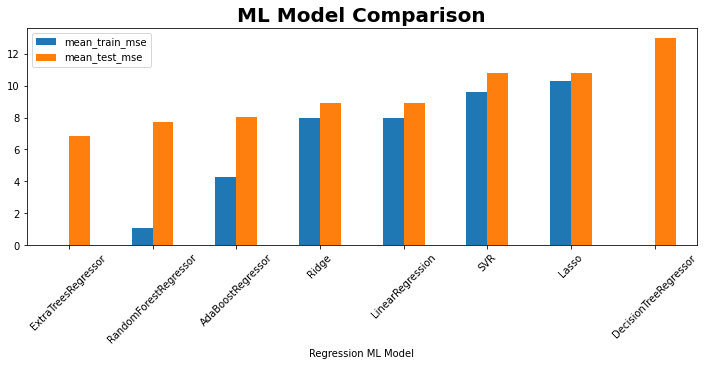

In [41]:
model_compdf.sort_values('rank_test_score').plot(x='param_reg_name', y=['mean_train_mse', 'mean_test_mse'],
                                                 kind='bar', figsize=(12, 4))
plt.xticks(rotation=45);
plt.title('ML Model Comparison', fontdict=dict(size=20, weight='bold'))
plt.xlabel('Regression ML Model')
plt.savefig('../reports/mlmodel_comparison.jpg')

* ExtraTreesRegressor performs the best but seems a bit overfitted with default params.
* AdaBoostRegressor peforms okayish and is also not very overfitted. Maybe (or not) we should use this model to further tune!
* DecisionTreeRegressor is a notorious overfitter!

## Tuning for the best `ML` Model

* We will peform hyperparameter tuning for the best ML model i.e. `ExtraTreesRegressor`

### Get the tree depths of `ExtraTreesClassifier`

https://stackoverflow.com/questions/34214087/how-do-you-access-tree-depth-in-pythons-scikit-learn

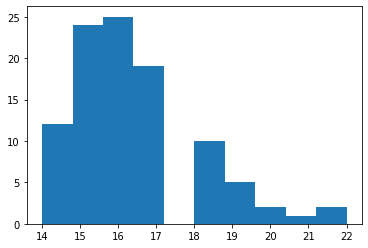

In [42]:
tree_depths = [est.get_depth() for est in grid_search.best_estimator_.named_steps['reg'].estimators_]
plt.hist(tree_depths);

In [43]:
extratrees_paramgrid = {'n_estimators': [2, 10, 20, 50, 100], 'max_features': [2, 4, 6, 8], 'max_depth': [8, 12, 16, 20]}
param_grid = {'reg': [ExtraTreesRegressor()], **{f'reg__{param}': vals for param, vals in extratrees_paramgrid.items()}}
param_grid

{'reg': [ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)],
 'reg__max_depth': [8, 12, 16, 20],
 'reg__max_features': [2, 4, 6, 8],
 'reg__n_estimators': [2, 10, 20, 50, 100]}

In [44]:
%%time

grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
grid_search.fit(dfX_train, y_train)

CPU times: user 2.34 s, sys: 37.4 ms, total: 2.38 s
Wall time: 23.6 s


In [45]:
grid_search.best_params_

{'reg': ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                     max_depth=20, max_features=8, max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=None, oob_score=False,
                     random_state=None, verbose=0, warm_start=False),
 'reg__max_depth': 20,
 'reg__max_features': 8,
 'reg__n_estimators': 100}

In [46]:
-grid_search.best_score_

6.630369713244042

## Feature Importance

In [47]:
best_model = grid_search.best_estimator_
feature_importances = pd.DataFrame(zip(PREPROCESSED_COLUMNS, best_model.named_steps['reg'].feature_importances_), 
                                   columns=['feature', 'importance']).sort_values('importance', ascending=False)
feature_importances

,feature,importance
12,origin_3,0.241497
11,origin_2,0.185271
0,cylinder,0.145648
1,displacement,0.102529
5,model_year,0.093504
2,horsepower,0.082136
3,weight,0.065726
10,origin_1,0.028819
9,acceleration_on_cylinder,0.018275
4,acceleration,0.014466


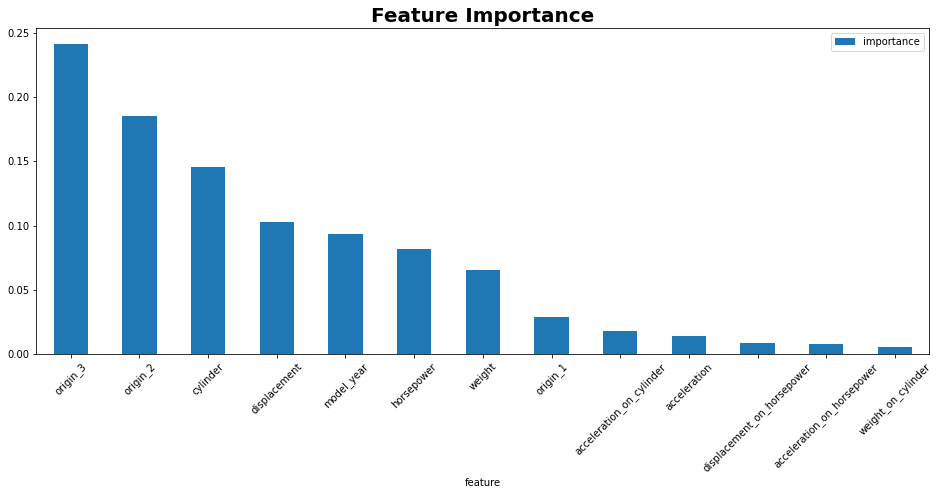

In [48]:
feature_importances.plot(x='feature', y='importance', kind='bar', figsize=(16, 6))
plt.xticks(rotation=45);
plt.title('Feature Importance', fontdict=dict(size=20, weight='bold'))
plt.savefig('../reports/feature_importance.jpg')

In [49]:
feature_importances.to_csv('../reports/extratrees_feature_importance.csv')

## Evaluate on Test Data

In [50]:
from sklearn.metrics import mean_squared_error

y_test_pred = best_model.predict(dfX_test)
mean_squared_error(y_test_pred, y_test) # Test MSE

6.8953136770833225

## Save the Model

In [51]:
import joblib

best_reg = best_model.named_steps['reg']

joblib.dump(best_reg, '../models/extratrees.pkl')

## Save the preprocessor `Pipeline`

In [62]:
best_preprocessor = best_model.named_steps['preprocess']
joblib.dump(best_preprocessor, '../models/preprocessor.pkl')

['../models/preprocessor.pkl']

## Prediction Function

- The prediction function will take a JSON like object (dictionary) as the input. We will call this config.
- The config will hold attribute-value pairs, and the values will be a list (this will help generalize the operation for vectorization i.e. if we have multiple inferences to make)
    - either a dictionary with values as list
    - or a list with each record as a dictionary
    
- The output will be a numpy array of predictions

In [89]:
COLUMN_ORDER = ['cylinder', 'displacement', 'horsepower', 'weight', 
                'acceleration','model_year', 'origin']

In [92]:
def predict_mpg(config, mlmodel, preprocessor):
    if isinstance(config, (list, dict)):
        df = pd.DataFrame(config)
    else:
        df = config

    df = df[COLUMN_ORDER]

    df_prep = preprocessor.transform(df)
    preds = mlmodel.predict(df_prep)

    return preds

In [93]:
predict_mpg(dfX_test.to_dict(orient='records')[0:1], best_reg, best_preprocessor)

array([17.205])